# 키보드 멀티 레이블 분류

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random

import torch
import torchvision.transforms as T

import timm

from sklearn.metrics import f1_score

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# Data 확인

In [3]:
annot_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/10/data/annotations.csv')
annot_df

,filename,black,white,blue,full,mini,tenkeyless
0,black_mini_keyboard/black_mini_keyboard_65.jpg,1,0,0,0,1,0
1,black_mini_keyboard/black_mini_keyboard_71.jpg,1,0,0,0,1,0
2,black_mini_keyboard/black_mini_keyboard_59.jpg,1,0,0,0,1,0
3,black_mini_keyboard/black_mini_keyboard_159.jpg,1,0,0,0,1,0
4,black_mini_keyboard/black_mini_keyboard_165.jpg,1,0,0,0,1,0
...,...,...,...,...,...,...,...
1631,blue_tenkeyless_keyboard/blue_tenkeyless_keybo...,0,0,1,0,0,1
1632,blue_tenkeyless_keyboard/blue_tenkeyless_keybo...,0,0,1,0,0,1
1633,blue_tenkeyless_keyboard/blue_tenkeyless_keybo...,0,0,1,0,0,1
1634,blue_tenkeyless_keyboard/blue_tenkeyless_keybo...,0,0,1,0,0,1


In [4]:
# 데이터를 무작위로 섞어준다. -> 순서대로 되어 있는 경우 특정 라벨만 학습에 사용될 수 있다.
annot_df = annot_df.sample(frac=1).reset_index(drop=True)
annot_df

,filename,black,white,blue,full,mini,tenkeyless
0,white_mini_keyboard/white_mini_keyboard_92.jpg,0,1,0,0,1,0
1,blue_tenkeyless_keyboard/blue_tenkeyless_keybo...,0,0,1,0,0,1
2,black_full_keyboard/black_full_keyboard_8.jpg,1,0,0,1,0,0
3,white_mini_keyboard/white_mini_keyboard_14.jpg,0,1,0,0,1,0
4,black_tenkeyless_keyboard/black_tenkeyless_key...,1,0,0,0,0,1
...,...,...,...,...,...,...,...
1631,blue_mini_keyboard/blue_mini_keyboard_160.jpg,0,0,1,0,1,0
1632,blue_mini_keyboard/blue_mini_keyboard_180.jpg,0,0,1,0,1,0
1633,white_full_keyboard/white_full_keyboard_147.jpg,0,1,0,1,0,0
1634,blue_tenkeyless_keyboard/blue_tenkeyless_keybo...,0,0,1,0,0,1


/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


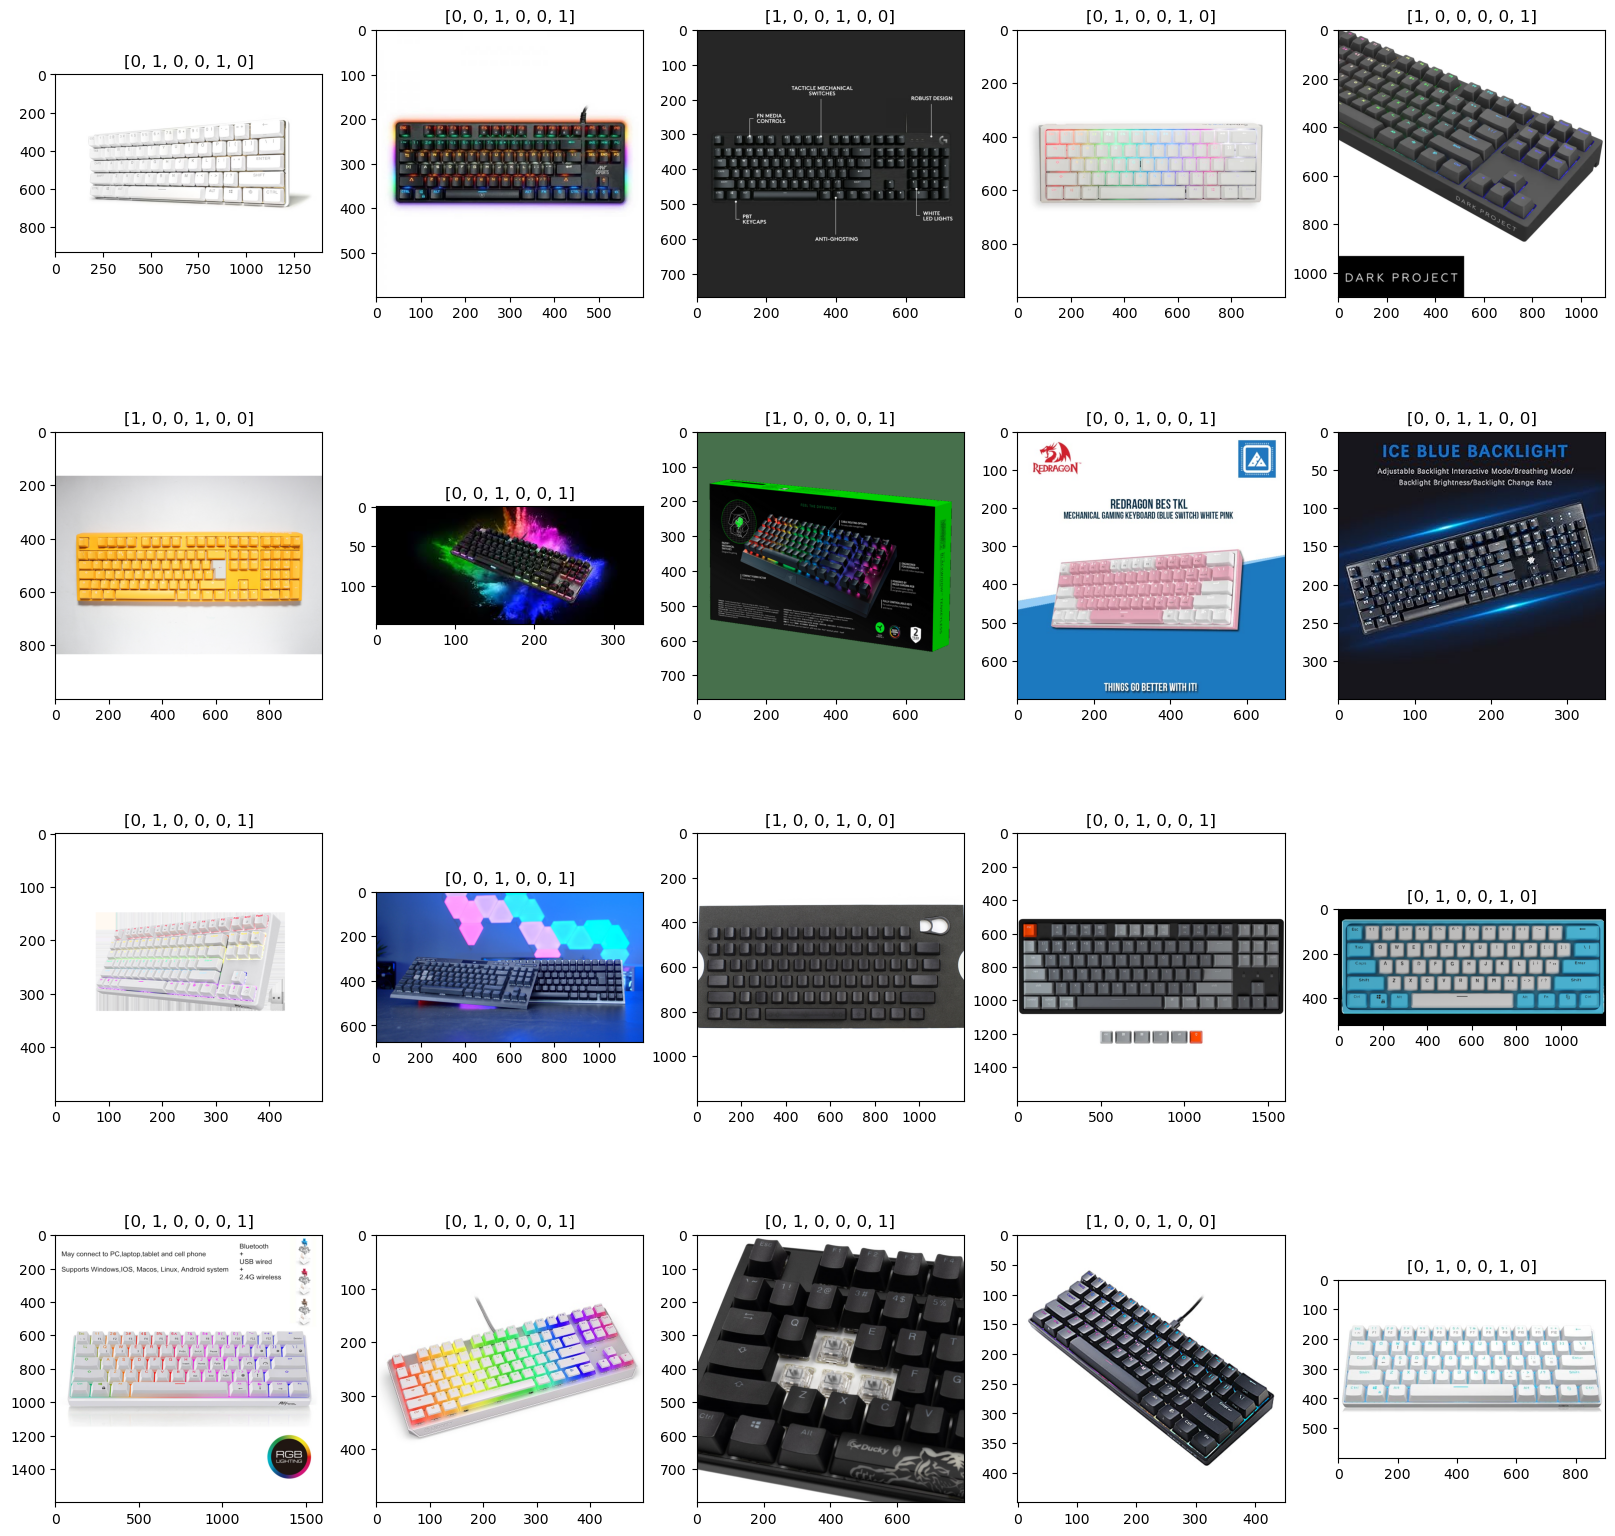

In [5]:
root_path = '/Users/kimhongseok/cv_79_projects/part1/chapter3/10/data'
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    img = Image.open(os.path.join(root_path, annot_df.iloc[i, 0])).convert('RGB')
    labels = annot_df.iloc[i, 1:].tolist()

    plt.imshow(img)
    plt.title(labels)

# CustomDataset

In [18]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, annot_df, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms
        n = annot_df.shape[0]

        for i in range(n):
            img = os.path.join(root_path, annot_df.iloc[i, 0])
            label = torch.tensor(annot_df.iloc[i, 1:].tolist()).float()
            self.data.append((img, label))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [19]:
transforms = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor()
])

total_dataset = CustomDataset(root_path, annot_df, transforms)

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


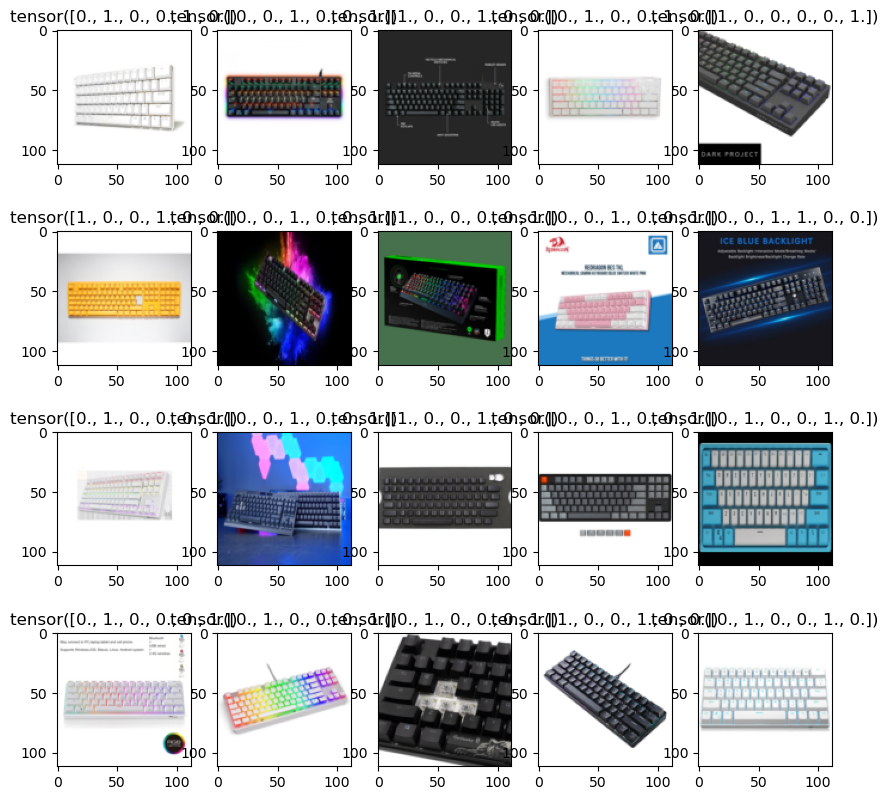

In [20]:
plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_dataset[i][0].permute(1, 2, 0))
    plt.title(total_dataset[i][1])

In [21]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, (train_num+2, valid_num, test_num))

In [22]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

1310 163 163


In [23]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# train, eval

In [24]:
def training(model, train_dataloader, threshold, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > threshold).float()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_f1 = f1_score(total_preds, total_labels, average='macro')

    return model, train_loss, train_f1

def evaluation(model, valid_dataloader, threshold, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs)>threshold).float()
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, threshold, criterion, optimizer, num_epochs):
    model.to(device)
    
    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, threshold, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_f1 = evaluation(model, valid_dataloader, threshold, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train F1: {train_f1}, Valid Loss: {valid_loss}, Valid F1: {valid_f1}')

    return model

# model

In [25]:
model = timm.create_model(
    'resnet18',
    num_classes=6,
    pretrained=True
)

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [26]:
for params in model.parameters():
    params.require_grads = False

for params in model.fc.parameters():
    params.require_grads = True

In [27]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
threshold = 0.5

model = training_loop(model, train_dataloader, valid_dataloader, threshold, criterion, optimizer, 10)

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.5996763720744993, Train F1: 0.2116968197410405, Valid Loss: 0.5686556895573934, Valid F1: 0.3161812196055506


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.4795058028000157, Train F1: 0.5298803723027777, Valid Loss: 0.5129511803388596, Valid F1: 0.492170786274722


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3799776950987374, Train F1: 0.7243838683436531, Valid Loss: 0.5151904771725336, Valid F1: 0.5993912321279878


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.26844654504845783, Train F1: 0.8305950698621185, Valid Loss: 0.5033308615287145, Valid F1: 0.6638075581153718


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1952602011038036, Train F1: 0.884202921976965, Valid Loss: 0.5209384709596634, Valid F1: 0.6369976131005542


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.15329774596342227, Train F1: 0.9131079221491696, Valid Loss: 0.5673135370016098, Valid F1: 0.6383390365053135


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.11714368240862358, Train F1: 0.9351011755142496, Valid Loss: 0.4879501909017563, Valid F1: 0.6969920839833845


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.09732139119651259, Train F1: 0.9454925613647848, Valid Loss: 0.7504873474438986, Valid F1: 0.6748508452053236


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.08484159037470818, Train F1: 0.9533812963781424, Valid Loss: 0.6823888669411341, Valid F1: 0.643191206941207


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.07433523900988626, Train F1: 0.9537343426804902, Valid Loss: 0.6936945617198944, Valid F1: 0.648404946794071


# test

In [28]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>threshold)

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

  0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [29]:
f1_score(total_labels, total_preds, average='macro')

0.6566522275051594

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


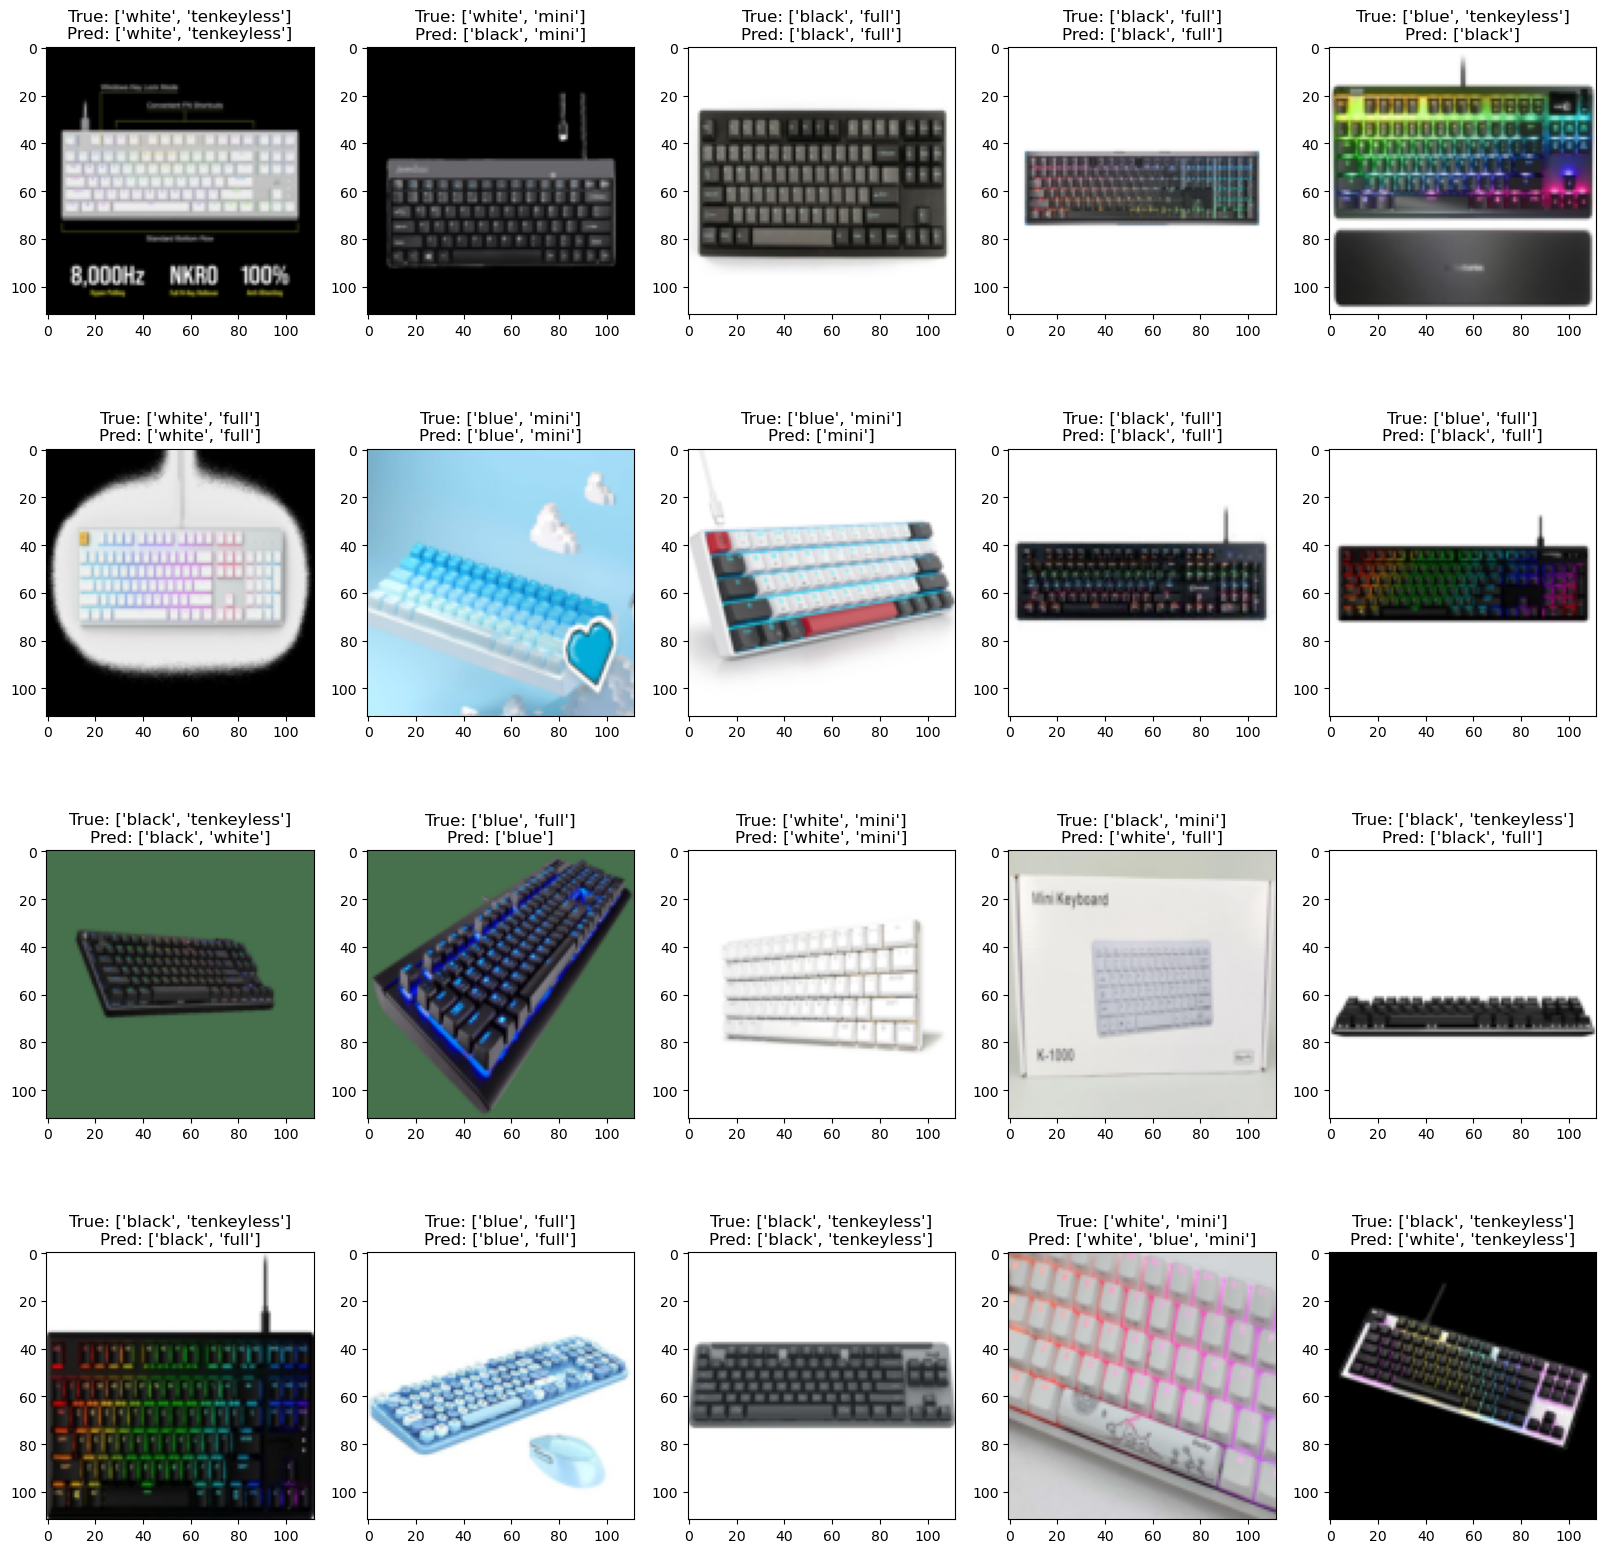

In [33]:
classes = ['black', 'white', 'blue', 'full', 'mini', 'tenkeyless']
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    true_labels = []
    pred_labels = []
    img = test_dataset[i][0].permute(1, 2, 0)

    for j in range(6):
        if total_labels[i][j] == 1:
            true_labels.append(classes[j])
        if total_preds[i][j] == 1:
            pred_labels.append(classes[j])

    plt.imshow(img)
    plt.title(f'True: {true_labels}\nPred: {pred_labels}')